# Tutorial on Variational Quantum Eigensolver (Part II)
## Inside the *Qiskit* implementation of VQE
---
This part of the tutorial is completely based on the [Max-Cut and Traveling Salesman Problem](https://qiskit.org/documentation/tutorials/optimization/6_examples_max_cut_and_tsp.html) which is part of the IBM Qiskit documentation.

During this Tutorial we will use the VQE implementation of Qiskit and investigate what is going on.

To that end we will continue working with the same 'Max-Cut' algorithm we saw last time.
........



## Import libraries 

We import all necessary functions from IBM qiskit and numpy python **libraries**, that we will later use on this Notebook.


In [2]:
# useful additional packages
import matplotlib.pyplot as plt
import matplotlib.axes as axes
%matplotlib inline
import numpy as np
import networkx as nx

# Import Qiskit libraries
from qiskit import Aer
from qiskit.tools.visualization import plot_histogram
from qiskit.circuit.library import TwoLocal
from qiskit.optimization.applications.ising import max_cut, tsp
from qiskit.aqua.algorithms import VQE, NumPyMinimumEigensolver
from qiskit.aqua.components.optimizers import SPSA
from qiskit.aqua import aqua_globals, QuantumInstance
from qiskit.optimization.applications.ising.common import sample_most_likely
from qiskit.optimization.algorithms import MinimumEigenOptimizer
from qiskit.optimization.problems import QuadraticProgram

# setup aqua logging
import logging
from qiskit.aqua import set_qiskit_aqua_logging
#set_qiskit_aqua_logging(logging.INFO)  # choose INFO, DEBUG to see the log

## Bla   ############# EDIT


[[0. 3. 1. 3. 0.]
 [3. 0. 0. 0. 2.]
 [1. 0. 0. 3. 0.]
 [3. 0. 3. 0. 2.]
 [0. 2. 0. 2. 0.]]


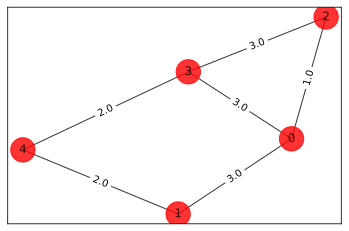

In [6]:
# Generating a graph of 5 nodes

n=5 # Number of nodes in graph
G=nx.Graph()
G.add_nodes_from(np.arange(0,n,1))
elist=[(0,1,3.0),(0,2,1.0),(0,3,3.0),(1,4,2.0),(3,4,2.0),(2,3,3.0)]
# tuple is (i,j,weight) where (i,j) is the edge

G.add_weighted_edges_from(elist)

colors = ['r' for node in G.nodes()]
pos = nx.spring_layout(G)

def draw_graph(G, colors, pos):
    default_axes = plt.axes(frameon=True)
    nx.draw_networkx(G, node_color=colors, node_size=600, alpha=.8, ax=default_axes, pos=pos)
    edge_labels = nx.get_edge_attributes(G, 'weight')
    nx.draw_networkx_edge_labels(G, pos=pos, edge_labels=edge_labels)

# Computing the weight matrix from the random graph
w = np.zeros([n,n])
for i in range(n):
    for j in range(n):
        temp = G.get_edge_data(i,j,default=0)
        if temp != 0:
            w[i,j] = temp['weight']


draw_graph(G, colors, pos)
print(w)


# Classical Approaches
## Brute Force Approach $2^n$ calculations.


Best solution = [0, 1, 0, 1, 0] cost = 13.0


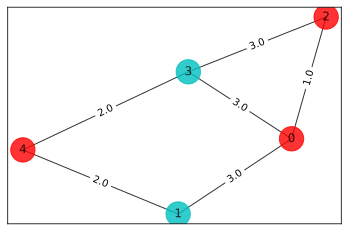

In [11]:
best_cost_brute = 0
for b in range(2**n):
    x = [int(t) for t in reversed(list(bin(b)[2:].zfill(n)))]
    cost = 0
    for i in range(n):
        for j in range(n):
            cost = cost + w[i,j]*x[i]*(1-x[j])
    if best_cost_brute < cost:
        best_cost_brute = cost
        xbest_brute = x
    #print('case = ' + str(x)+ ' cost = ' + str(cost))

colors = ['r' if xbest_brute[i] == 0 else 'c' for i in range(n)]
draw_graph(G, colors, pos)
print('\nBest solution = ' + str(xbest_brute) + ' cost = ' + str(best_cost_brute))

## Classical eigensolver for Quadratic Problem with Ising Hamiltonian

In [12]:
# Create MaxCut Hamiltonian Operator with Qiskit
qubitOp, offset = max_cut.get_operator(w)
print('Offset:', offset)
print('Ising Hamiltonian:')
print(qubitOp.print_details())

# mapping Ising Hamiltonian to Quadratic Program and solving using exact classical eigensolver
qp = QuadraticProgram()
qp.from_ising(qubitOp, offset)
qp.to_docplex().prettyprint()

exact = MinimumEigenOptimizer(NumPyMinimumEigensolver())
result = exact.solve(qp)
print(result)

Offset: -7.0
Ising Hamiltonian:
IIIZZ	(1.5+0j)
IIZIZ	(0.5+0j)
IZIIZ	(1.5+0j)
IZZII	(1.5+0j)
ZIIZI	(1+0j)
ZZIII	(1+0j)

// This file has been generated by DOcplex
// model name is: AnonymousModel
// single vars section
dvar bool x_0;
dvar bool x_1;
dvar bool x_2;
dvar bool x_3;
dvar bool x_4;

minimize
 [ - 7 x_0^2 + 6 x_0*x_1 + 2 x_0*x_2 + 6 x_0*x_3 - 5 x_1^2 + 4 x_1*x_4
 - 4 x_2^2 + 6 x_2*x_3 - 8 x_3^2 + 4 x_3*x_4 - 4 x_4^2 ];
 
subject to {

}
optimal function value: -13.0
optimal value: [0. 1. 0. 1. 0.]
status: SUCCESS


energy: -6.0
max-cut objective: -13.0
solution: [1 0 1 0 1]
solution objective: 13.0


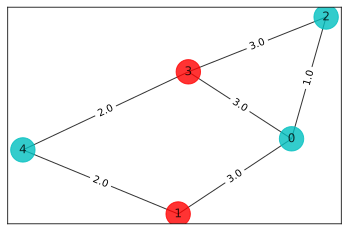

In [13]:
#Making the Hamiltonian in its full form and getting the lowest eigenvalue and eigenvector
ee = NumPyMinimumEigensolver(qubitOp)
result = ee.run()

x = sample_most_likely(result.eigenstate)
print('energy:', result.eigenvalue.real)
print('max-cut objective:', result.eigenvalue.real + offset)
print('solution:', max_cut.get_graph_solution(x))
print('solution objective:', max_cut.max_cut_value(x, w))

colors = ['r' if max_cut.get_graph_solution(x)[i] == 0 else 'c' for i in range(n)]
draw_graph(G, colors, pos)

# Quantum Approaches
## Quantum Simulation with VQE

In [14]:
aqua_globals.random_seed = np.random.default_rng(123)
seed = 10598
backend = Aer.get_backend('statevector_simulator')
quantum_instance = QuantumInstance(backend, seed_simulator=seed, seed_transpiler=seed)

energy: -5.983735567440303
time: 2.5342752933502197
max-cut objective: -12.983735567440302
solution: [0. 1. 0. 1. 0.]
solution objective: 13.0


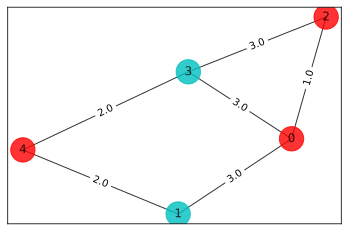

In [15]:
# construct VQE
spsa = SPSA(maxiter=300)
ry = TwoLocal(qubitOp.num_qubits, 'ry', 'cz', reps=5, entanglement='linear')
vqe = VQE(qubitOp, ry, spsa, quantum_instance=quantum_instance)

# run VQE
result = vqe.run(quantum_instance)

# print results
x = sample_most_likely(result.eigenstate)
print('energy:', result.eigenvalue.real)
print('time:', result.optimizer_time)
print('max-cut objective:', result.eigenvalue.real + offset)
print('solution:', max_cut.get_graph_solution(x))
print('solution objective:', max_cut.max_cut_value(x, w))

# plot results
colors = ['r' if max_cut.get_graph_solution(x)[i] == 0 else 'c' for i in range(n)]
draw_graph(G, colors, pos)

optimal function value: -13.0
optimal value: [0. 1. 0. 1. 0.]
status: SUCCESS


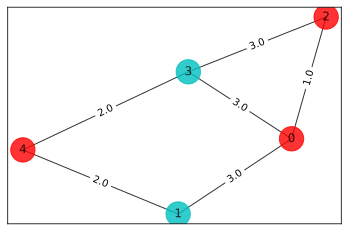

In [16]:
# create minimum eigen optimizer based on VQE
vqe_optimizer = MinimumEigenOptimizer(vqe)

# solve quadratic program
result = vqe_optimizer.solve(qp)
print(result)

colors = ['r' if result.x[i] == 0 else 'c' for i in range(n)]
draw_graph(G, colors, pos)

---
This part of the tutorial is completely based on the [Max-Cut and Traveling Salesman Problem](https://qiskit.org/documentation/tutorials/optimization/6_examples_max_cut_and_tsp.html) which is part of the IBM Qiskit documentation.

---